In [40]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()
import MathOptInterface as MOI
import Ipopt 
import FiniteDiff
import ForwardDiff
import Convex as cvx 
import ECOS
using LinearAlgebra
using Plots
using Random
using JLD2
using Test
import MeshCat as mc 
using Statistics 

  Activating environment at `/home/sman/Work/CMU/Courses/OCRL/OCRL2024/HW/HW3_S24/Project.toml`


In [41]:
include(joinpath(@__DIR__, "utils","fmincon.jl"))
include(joinpath(@__DIR__, "utils";"planar_quadrotor.jl"))

ErrorException: syntax: invalid keyword argument syntax ""planar_quadrotor.jl"" around /home/sman/Work/CMU/Courses/OCRL/OCRL2024/HW/HW3_S24/Q3.ipynb:2

# Q3: Quadrotor Reorientation (40 pts)

In this problem, you will use the trajectory optimization tools you have demonstrated in questions one and two to solve for a collision free reorientation of three planar quadrotors. The planar quadrotor (as described in lecture 9) is described with the following state and dynamics: 

$$\begin{align} x = \begin{bmatrix} p_x \\ p_z \\ \theta \\ v_x \\ v_z \\ \omega \end{bmatrix}, &\quad \quad  \end{align} \dot{x} = \begin{bmatrix}v_x \\ v_z \\ \omega \\ \frac{1}{m}(u_1 + u_2)\sin\theta \\ \frac{1}{m}(u_1 + u_2)\cos\theta \\ \frac{\ell}{2J}(u_2 - u_1)\end{bmatrix} $$ 

where $p_x$ and $p_z$ are the horizontal and vertial positions, $v_x$ and $v_z$ are the corresponding velocities, $\theta$ for orientation, $\omega$ for angular velocity, $\ell$ for length of the quadrotor, $m$ for mass, $g$ for gravity acceleration in the $-z$ direction, and a moment of inertia of $J$. 

You are free to use any solver/cost/constraint you would like to solve for three collision free, dynamically feasible trajectories for these quadrotors that looks something like the following:

<div>
<img src="attachment:quadrotor_reorient.gif" width="500"/>
</div>

(if an animation doesn't load here, check out `quadrotor_reorient.gif`.) 

Here are the performance requirements that the resulting trajectories must meet: 

- The three quadrotors must start at `x1ic`, `x2ic`, and `x2ic` as shown in the code (these are the initial conditions).

- The three quadrotors must finish their trajectories within **.2** meters of `x1g`, `x2g`, and `x2g` (these are the goal states). 

- The three quadrotors must never be within **0.8** meters of one another (use $[p_x,p_z]$ for this).

There are two main ways of going about this:

1. **Cost Shaping**: Design cost functions for each quadrotor that motivates them to take paths that do not result in a collision. You can do something like designing a reference trajectory for each quadrotor to use in the cost. You can use iLQR or DIRCOL for this.  

2. **Collision Constraints**: You can optimize over all three quadrotors at once by creating a new state $\tilde{x} = [x_1^T,x_2^T,x_3^T]^T$ and control $\tilde{u} = [u_1^T,u_2^T,u_3^T]^T$, and then directly include collision avoidance constraints.  In order to use constraints, you must use DIRCOL (at least for now). 

### Hints

- You should not use `norm() >= R` in any constraints, instead you should square the constraint to be `norm()^2 >= R^2`. This second constraint is still non-convex, but it is differentiable everywhere. 

- If you are using DIRCOL, you can initialize the solver with a "guess" solution by linearly interpolating between the initial and terminal conditions. Julia let's you create a length N linear interpolated vector of vectors between `a::Vector` and `b::Vector` like this: `range(a, b, length = N)` (experiment with this to see how it works). 

You can use either RK4 (iLQR or DIRCOL) or Hermite-Simpson (DIRCOL) for your integration. The `dt = 0.2`, and `tf = 5.0` are given for you in the code (you may change these but only if you feel you really have to). 

In [42]:
function single_quad_dynamics(params, x,u)
    # planar quadrotor dynamics for a single quadrotor 

    # unpack state
    px,pz,θ,vx,vz,ω = x  
    
    xdot = [
        vx,
        vz,
        ω,
        (1/params.mass)*(u[1] + u[2])*sin(θ),
        (1/params.mass)*(u[1] + u[2])*cos(θ) - params.g,
        (params.ℓ/(2*params.J))*(u[2]-u[1])
    ]
    
    return xdot
end
function combined_dynamics(params, x,u)
    # dynamics for three planar quadrotors, assuming the state is stacked
    # in the following manner: x = [x1;x2;x3]
    
    # NOTE: you would only need to use this if you chose option 2 where 
    # you optimize over all three trajectories simultaneously 
    
    # quadrotor 1 
    x1 = x[1:6]
    u1 = u[1:2]
    xdot1 = single_quad_dynamics(params, x1, u1)
    
    # quadrotor 2
    x2 = x[(1:6) .+ 6]
    u2 = u[(1:2) .+ 2]
    xdot2 = single_quad_dynamics(params, x2, u2)
    
    # quadrotor 3
    x3 = x[(1:6) .+ 12]
    u3 = u[(1:2) .+ 4]
    xdot3 = single_quad_dynamics(params, x3, u3)
    
    # return stacked dynamics 
    return [xdot1;xdot2;xdot3]
end

combined_dynamics (generic function with 1 method)

In [153]:
function create_idx(nx,nu,N)
    # This function creates some useful indexing tools for Z  
    # Feel free to use/not use anything here.
    # our Z vector is [x0, u0, x1, u1, …, xN]
    nz = (N-1) * nu + N * nx # length of Z 
    x = [(i - 1) * (nx + nu) .+ (1 : nx) for i = 1:N]
    u = [(i - 1) * (nx + nu) .+ ((nx + 1):(nx + nu)) for i = 1:(N - 1)]
    
    # constraint indexing for the (N-1) dynamics constraints when stacked up
    c = [(i - 1) * (nx) .+ (1 : nx) for i = 1:(N - 1)]
    nc = (N - 1) * nx # (N-1)*nx 
    return (nx=nx,nu=nu,N=N,nz=nz,nc=nc,x= x,u = u,c = c)
end

function hermite_simpson(params::NamedTuple, x1::Vector, x2::Vector, u, dt::Real)::Vector
    # TODO: input hermite simpson implicit integrator residual 
    ẋ_k = combined_dynamics(params, x1, u)
    ẋ_kp1 = combined_dynamics(params, x2, u)
    x_kpm = 1/2*(x1 + x2) + dt/8*(ẋ_k - ẋ_kp1)
    ẋ_kpm = combined_dynamics(params, x_kpm, u)
    res = x1 + dt/6*(ẋ_k + 4*ẋ_kpm + ẋ_kp1) - x2
    return res
end

function quad_cost(params::NamedTuple, Z::Vector)::Real
    idx, N, x1g, x2g, x3g = params.idx, params.N, params.x1g, params.x2g, params.x3g
    Q, R, Qf = params.Q, params.R, params.Qf
    # TODO: input cartpole LQR cost 
    J = 0 
    xg = [x1g;x2g;x2g]
    for i = 1:(N-1)
        xi = Z[idx.x[i]]
        ui = Z[idx.u[i]]
        J += 1 / 2 *( (xi - xg)' * Q * (xi - xg) + ui' * R * ui)
    end
    xn = Z[idx.x[N]]
    # dont forget terminal cost 
    J += 1 / 2 * (xn - xg)' * Qf * (xn - xg)
    return J
end

function quad_dynamics_constraints(params::NamedTuple, Z::Vector)::Vector
    idx, N, dt = params.idx, params.N, params.dt
    # TODO: create dynamics constraints using hermite simpson 
    # create c in a ForwardDiff friendly way (check HW0)
    c = zeros(eltype(Z), idx.nc)
    for i = 1:(N-1)
        xi = Z[idx.x[i]]
        ui = Z[idx.u[i]] 
        xip1 = Z[idx.x[i+1]]
        # TODO: hermite simpson 
        c[idx.c[i]] = hermite_simpson(params, xi, xip1, ui, dt)
    end
    return c 
end

function quad_equality_constraint(params::NamedTuple, Z::Vector)::Vector
    idx, N, x1ic, x2ic, x3ic, x1g, x2g, x3g = params.idx, params.N, params.x1ic, params.x2ic, params.x3ic, params.x1g, params.x2g, params.x3g
    # TODO: return all of the equality constraints 
    x0 = Z[idx.x[1]]
    x01 = x0[1:6]
    x02 = x0[7:12]
    x03 = x0[13:18]
    xN = Z[idx.x[end]]
    # eq_cons = [quad_dynamics_constraints(params, Z); (x0 - [x1ic;x2ic;x3ic]); (xN - [x1g;x2g;x3g])]
    eq_cons = [quad_dynamics_constraints(params, Z); (x01 - x1ic); (x02 - x2ic) ; (x03 - x3ic) ; (xN - [x1g;x2g;x3g])]
    return eq_cons
end

function quad_inequality_constraint(params::NamedTuple, Z::Vector)::Vector
    # TODO: create inequality constraint function with params and x 
    idx, N, Rc= params.idx, params.N, params.Rc
    ineq_cons = []
    for i = 1:(N-1)
        xi = Z[idx.x[i]] 
        xi1 = [xi[1]; xi[2]]
        xi2 = [xi[7]; xi[8]]
        xi3 = [xi[13]; xi[14]]
        # d12 = norm(xi1-xi2)^2
        # d23 = norm(xi2-xi2)^2
        # d13 = norm(xi1-xi3)^2

        d12 = norm(xi1-xi2)^2
        d23 = norm(xi2-xi3)^2
        d13 = norm(xi1-xi3)^2
        ineq_cons = [ineq_cons; d12-Rc^2; d23-Rc^2; d13-Rc^2]
    end
    return ineq_cons
end


quad_inequality_constraint (generic function with 1 method)

In [158]:
"""
    quadrotor_reorient

Function for returning collision free trajectories for 3 quadrotors. 

Outputs:
    x1::Vector{Vector}  # state trajectory for quad 1 
    x2::Vector{Vector}  # state trajectory for quad 2 
    x3::Vector{Vector}  # state trajectory for quad 3 
    u1::Vector{Vector}  # control trajectory for quad 1 
    u2::Vector{Vector}  # control trajectory for quad 2 
    u3::Vector{Vector}  # control trajectory for quad 3 
    t_vec::Vector
    params::NamedTuple

The resulting trajectories should have dt=0.2, tf = 5.0, N = 26
where all the x's are length 26, and the u's are length 25. 

Each trajectory for quad k should start at `xkic`, and should finish near 
`xkg`. The distances between each quad should be greater than 0.8 meters at 
every knot point in the trajectory. 
"""
function quadrotor_reorient(;verbose=true)
    
    # problem size 
    nx = 18 
    nu = 6
    dt = 0.2
    tf = 5.0 
    t_vec = 0:dt:tf 
    N = length(t_vec)
    
    # indexing 
    idx = create_idx(nx,nu,N)
    
    # initial conditions and goal states 
    lo = 0.5 
    mid = 2 
    hi = 3.5 
    x1ic = [-2,lo,0,0,0,0]  # ic for quad 1 
    x2ic = [-2,mid,0,0,0,0] # ic for quad 2 
    x3ic = [-2,hi,0,0,0,0]  # ic for quad 3 

    x1g = [2,mid,0,0,0,0]   # goal for quad 1 
    x2g = [2,hi,0,0,0,0]    # goal for quad 2 
    x3g = [2,lo,0,0,0,0]    # goal for quad 3 

    Q = diagm(ones(nx))
    R = 0.1*diagm(ones(nu))
    Qf = 10*diagm(ones(nx))
    
    # load all useful things into params 
    # TODO: include anything you would need for a cost function (like a Q, R, Qf if you were doing an 
    # LQR cost)
    params = (Q=Q,
              R=R,
              Qf=Qf,
              x1ic=x1ic,
              x2ic=x2ic,
              x3ic=x3ic,
              x1g = x1g,
              x2g = x2g,
              x3g = x3g,
              dt = dt,
              N = N,
              idx = idx,
              mass = 1.0, # quadrotor mass 
              g = 9.81,   # gravity 
              ℓ = 0.3,    # quadrotor length 
              J = .018,   # quadrotor moment of inertia 
              Rc = 0.8,   # minimum dist between quadrotors
              )   
    
    # TODO: solve for the three collision free trajectories however you like

    diff_type = :auto 

    z0 = vcat(collect(range([x1ic;x2ic;x3ic;zeros(nu)], [x1g;x2g;x3g;zeros(nu)],length=N))...)
    z0 = z0[1:end-6]
    
    x_l = -Inf*ones(length(z0))
    x_u = Inf*ones(length(z0))

    c_u = Inf*ones(length(quad_inequality_constraint(params,z0)))
    c_l = zeros(length(quad_inequality_constraint(params,z0)))

    Z = fmincon(quad_cost,quad_equality_constraint,quad_inequality_constraint,
                x_l,x_u,c_l,c_u,z0,params, diff_type;
                tol = 1e-7, c_tol = 1e-7, max_iters = 10_000, verbose = verbose)

    X = [Z[idx.x[i]] for i = 1:N]
    U = [Z[idx.u[i]] for i = 1:(N-1)]

    # return the trajectories 
    x1 = [X[i][1:6]  for i = 1:N]
    x2 = [X[i][7:12]  for i = 1:N]
    x3 = [X[i][13:18] for i = 1:N]
    u1 = [U[i][1:2] for i = 1:(N-1)]
    u2 = [U[i][3:4]  for i = 1:(N-1)]
    u3 = [U[i][5:6]  for i = 1:(N-1)]
        
    return x1, x2, x3, u1, u2, u3, t_vec, params 
end

quadrotor_reorient

---------checking dimensions of everything----------
---------all dimensions good------------------------
---------diff type set to :auto (ForwardDiff.jl)----
---------testing objective gradient-----------------
---------testing constraint Jacobian----------------
---------successfully compiled both derivatives-----
---------IPOPT beginning solve----------------------
This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:   300348
Number of nonzeros in inequality constraint Jacobian.:    46350
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      618
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      486
Total number of inequality constraints.......

┌ Info: Listening on: 127.0.0.1:8711, thread id: 1
└ @ HTTP.Servers /root/.julia/packages/HTTP/enKbm/src/Servers.jl:369
┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
│ http://127.0.0.1:8711
└ @ MeshCat /root/.julia/packages/MeshCat/QXID5/src/visualizer.jl:64


MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), UInt8[0x83, 0xa7, 0x6f, 0x70, 0x74, 0x69, 0x6f, 0x6e, 0x73, 0x82  …  0x5f, 0x61, 0x6e, 0x69, 0x6d, 0x61, 0x74, 0x69, 0x6f, 0x6e], Dict{String, MeshCat.SceneTrees.SceneNode}("meshcat" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("traj2" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("s23" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x2f, 0x74, 0x72, 0x61, 0x6a, 0x32, 0x2f, 0x73, 0x32, 0x33], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "s14" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x2f, 0x74, 0x72, 0x61, 0x6a, 0x32, 0x2f, 0x73, 0x31, 0x34], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "s18" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x2f, 0x74, 0x72, 0x61, 0x6a, 0x32, 0x2f, 0x73, 0x31, 0x38], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "s19" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x2f, 0x74, 0x72, 0x61, 0x6a, 0x32, 0x2f, 0x73, 0x31, 0x39], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "s6" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x74, 0x2f, 0x74, 0x72, 0x61, 0x6a, 0x32, 0x2f, 0x73, 0x36], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "s11" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x2f, 0x74, 0x72, 0x61, 0x6a, 0x32, 0x2f, 0x73, 0x31, 0x31], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "s15" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x2f, 0x74, 0x72, 0x61, 0x6a, 0x32, 0x2f, 0x73, 0x31, 0x35], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "p4" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x74, 0x2f, 0x74, 0x72, 0x61, 0x6a, 0x32, 0x2f, 0x70, 0x34], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "s17" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x2f, 0x74, 0x72, 0x61, 0x6a, 0x32, 0x2f, 0x73, 0x31, 0x37], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "s2" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x74, 0x2f, 0x74, 0x72, 0x61, 0x6a, 0x32, 0x2f, 0x73, 0x32], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}())…)), "vic3" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x73, 0x68, 0x63, 0x61, 0x74, 0x2f, 0x76, 0x69, 0x63, 0x33], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "traj3" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("s23" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x2f, 0x74, 0x72, 0x61, 0x6a, 0x33, 0x2f, 0x73, 0x32, 0x33], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "s14" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  

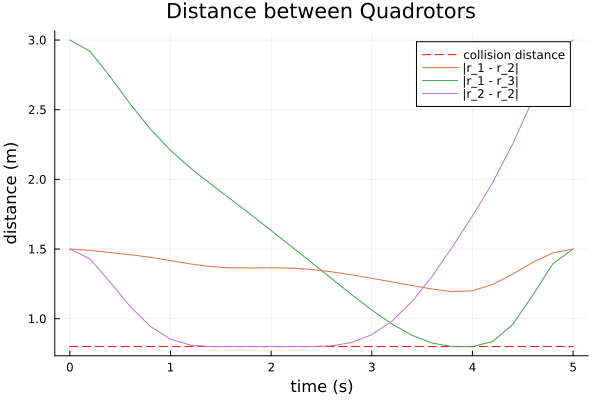

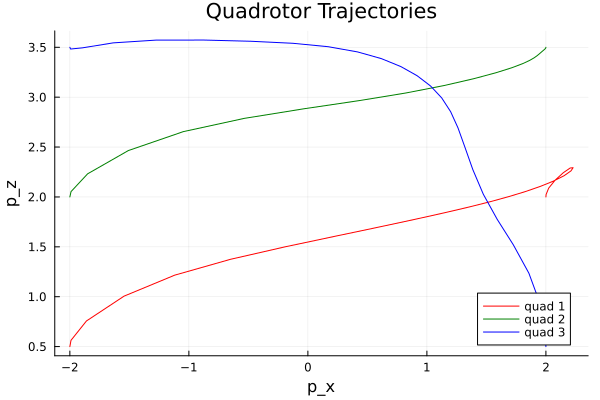

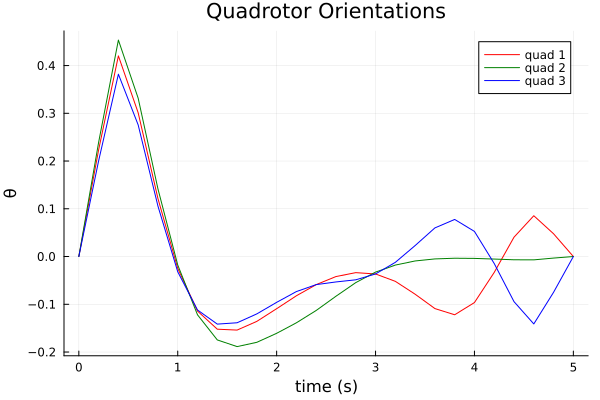

Test Summary:      | Pass  Total
quadrotor reorient |   14     14


Test.DefaultTestSet("quadrotor reorient", Any[], 14, false, false)

In [159]:
@testset "quadrotor reorient" begin 
    
    X1, X2, X3, U1, U2, U3, t_vec, params  = quadrotor_reorient(verbose=true)
    
    
    #---------------testing-----------------
    # check lengths of everything 
    @test length(X1) == length(X2) == length(X3)
    @test length(U1) == length(U2) == length(U3)
    @test length(X1) == params.N 
    @test length(U1) == (params.N-1)
    
    # check for collisions 
    distances = [distance_between_quads(x1[1:2],x2[1:2],x3[1:2]) for (x1,x2,x3) in zip(X1,X2,X3)]
    @test minimum(minimum.(distances)) >= 0.799
    
    # check initial and final conditions 
    @test norm(X1[1] - params.x1ic, Inf) <= 1e-3 
    @test norm(X2[1] - params.x2ic, Inf) <= 1e-3 
    @test norm(X3[1] - params.x3ic, Inf) <= 1e-3 
    @test norm(X1[end] - params.x1g, Inf) <= 2e-1 
    @test norm(X2[end] - params.x2g, Inf) <= 2e-1 
    @test norm(X3[end] - params.x3g, Inf) <= 2e-1 
    
    # check dynamic feasibility 
    @test check_dynamic_feasibility(params,X1,U1)
    @test check_dynamic_feasibility(params,X2,U2)
    @test check_dynamic_feasibility(params,X3,U3)
    
    
    #---------------plotting/animation-------
    display(animate_planar_quadrotors(X1,X2,X3, params.dt))
    
    plot(t_vec, 0.8*ones(params.N),ls = :dash, color = :red, label = "collision distance",
         xlabel = "time (s)", ylabel = "distance (m)", title = "Distance between Quadrotors")
    display(plot!(t_vec, hcat(distances...)', label = ["|r_1 - r_2|" "|r_1 - r_3|" "|r_2 - r_2|"]))
        
    X1m = hcat(X1...)
    X2m = hcat(X2...)
    X3m = hcat(X3...)
    
    plot(X1m[1,:], X1m[2,:], color = :red,title = "Quadrotor Trajectories", label = "quad 1")
    plot!(X2m[1,:], X2m[2,:], color = :green, label = "quad 2",xlabel = "p_x", ylabel = "p_z")
    display(plot!(X3m[1,:], X3m[2,:], color = :blue, label = "quad 3"))
    
    plot(t_vec, X1m[3,:], color = :red,title = "Quadrotor Orientations", label = "quad 1")
    plot!(t_vec, X2m[3,:], color = :green, label = "quad 2",xlabel = "time (s)", ylabel = "θ")
    display(plot!(t_vec, X3m[3,:], color = :blue, label = "quad 3"))
    
    
end